In [1]:
from Feed_Forward_NN import *
#from train_fn import *
from activation_fns_and_grads import *
from loss_fns_with_regularization import *
from optimizers_with_regularization import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import wandb

In [2]:
!wandb login

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)


In [3]:
wandb.init(project='Best model Fashion MNIST')

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)


In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root=r'C:\Users\Rayan Zaki\Desktop\Fundamentals of Deep Learning\Assignment 1'
    ,train=True
    ,download=False
    
)
test_set = torchvision.datasets.FashionMNIST(
    root=r'C:\Users\Rayan Zaki\Desktop\Fundamentals of Deep Learning\Assignment 1'
    ,train=False
    ,download=False
    
)

In [5]:
X_train = np.array(train_set.data)

Y_train = np.array(train_set.targets)

Y_train=Y_train.reshape(-1,1).T

X_train = X_train.reshape(X_train.shape[0],-1).T

In [6]:
X_train, X_val, Y_train, Y_val = train_val_split(X_train, Y_train, val_size=0.1, random_state=42)

In [7]:
# Prior to this define the model
def train(model,
      X_train = X_train,
      Y_train = Y_train,
      X_val = X_val,
      Y_val = Y_val,
      output_activation = "softmax",
      output_loss_fn = "cross_entropy",
      epochs = 50, 
      optimizer_name='adam',
      l2_lambd =0.05,
      learning_rate = 0.0002,
      lr_schedule = 0.4,
      batch_size = 512,
      print_cost = True, 
      val = True):
    
    train_costs_batches = []
    train_accuracy_batches = []
    
    train_costs=[]
    train_accuracy = []
    val_costs = []
    val_accuracy = []
    
    if optimizer_name=='sgd':
        optimizer = stochastic_gradient_descent(learning_rate=learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='momentum':
        optimizer = momentum_gradient_descent(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='rmsprop':
        optimizer = rms_prop(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='adam':
        optimizer = adam(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name== 'nesterov':
        optimizer = nesterov_gradient_descent(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='nadam':
        optimizer = nadam(params = model.params, learning_rate= learning_rate, beta1=0.9, beta2=0.999 , l2_lambd=l2_lambd)
        
    if batch_size==None:
        batch_size = X_train.shape[1]
        
    for i in range(1,epochs+1):
        if i%10==0:
            optimizer.lr=optimizer.lr * lr_schedule
        '''decay = 0.001
        optimizer.lr=optimizer.lr * 1/(1 + decay * i)'''
        
        mini_batches = create_mini_batches(X_train, Y_train, batch_size)
        no_batches = len(mini_batches)
        
        epoch_loss=0
        epoch_correct=0
        
        
        for j , mini_batch in enumerate(mini_batches,1):
            X_mini, Y_mini = mini_batch
            bs = X_mini.shape[1]
            if bs==0:
                break
            
            # Forward Propagation
            XL = model.forward_prop(X_mini) ## final layer output w/o activation
            Y_pred = act_fn(XL,output_activation)
            
            # Compute cost
            batch_cost = cost_fn(model.params,Y_mini,Y_pred, l2_lambd=l2_lambd, output_activation=output_activation, loss_fn=output_loss_fn)
            batch_correct = np.sum(onehot_to_class(Y_pred)==Y_mini)
            
            epoch_loss += batch_cost*bs
            epoch_correct += batch_correct
            
            # Backward propagation
            ## look forward step
            if optimizer_name=='nesterov' or optimizer_name=='nadam':
                optimizer.update_params_prior_grad(model)
            
            dZ=output_exc_act_grad(Y_mini,Y_pred,output_activation=output_activation,loss_fn=output_loss_fn,classes=model.output_nodes)

            model.backward_prop(dZ)

            # Update parameters.
            if optimizer_name== 'nesterov' or optimizer_name=='nadam':
                optimizer.update_params_after_grad(model)
            else:
                optimizer.update_params(model)

            # Print the cost every 100 training batch
            if j % 100 == 0:
                train_costs_batches.append(batch_cost)
                train_accuracy_batches.append(batch_correct/Y_mini.shape[1])
        
        epoch_loss = epoch_loss / X_train.shape[1]
        epoch_correct = epoch_correct / X_train.shape[1]
        
        train_costs.append(epoch_loss)
        train_accuracy.append(epoch_correct)
        wandb.log({'epoch': i,'train loss': epoch_loss,'train accuracy': epoch_correct})
        if val :
            val_acc,val_loss=accuracy_loss(model,X_val,Y_val,output_activation=output_activation,output_loss_fn=output_loss_fn)
            val_costs.append(val_loss)
            val_accuracy.append(val_acc)
            
            wandb.log({'val loss': val_loss,'val accuracy': val_acc})
            if print_cost:
                print("val cost for epoch ", i , "= ",val_loss)
                print("val accuracy for epoch ", i , "= ",val_acc)
                print("train cost for epoch ", i , "= ",epoch_loss)
                print("train accuracy for epoch ", i , "= ",epoch_correct)
                print("")
            
    # plot the cost per 100 batches
    plt.plot(np.squeeze(train_costs_batches))
    plt.plot(np.squeeze(train_accuracy_batches))
    plt.ylabel('train_costs_batches')
    plt.xlabel('batches (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    


In [8]:
nn=FeedForward_NN(input_features= 784, 
                  output_nodes=10, 
                  hidden_layers_dims=[256],
                  act_fn='relu',
                  dropout = 1, # with what probability u want nodes to be on
                  initialization='xavier')

val cost for epoch  1 =  0.5098706574147044
val accuracy for epoch  1 =  0.8195
train cost for epoch  1 =  0.6660448346106369
train accuracy for epoch  1 =  0.7733518518518518

val cost for epoch  2 =  0.4004944895996551
val accuracy for epoch  2 =  0.8548333333333333
train cost for epoch  2 =  0.4199994545634499
train accuracy for epoch  2 =  0.8546481481481482

val cost for epoch  3 =  0.37707987200580345
val accuracy for epoch  3 =  0.8643333333333333
train cost for epoch  3 =  0.36630951535512307
train accuracy for epoch  3 =  0.8731666666666666

val cost for epoch  4 =  0.3619205592408814
val accuracy for epoch  4 =  0.8698333333333333
train cost for epoch  4 =  0.3433163576890788
train accuracy for epoch  4 =  0.8795925925925926

val cost for epoch  5 =  0.375677300172263
val accuracy for epoch  5 =  0.8628333333333333
train cost for epoch  5 =  0.3180115462581091
train accuracy for epoch  5 =  0.8886851851851851

val cost for epoch  6 =  0.3380769068424021
val accuracy for epoch

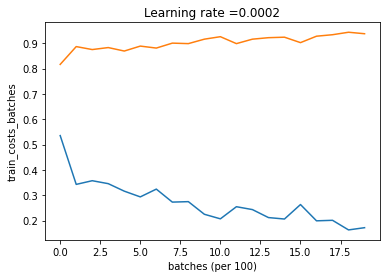

In [9]:
train(model=nn,
      X_train = X_train,
      Y_train = Y_train,
      X_val = X_val,
      Y_val = Y_val,
      output_activation = "softmax",
      output_loss_fn = "cross_entropy",
      epochs = 20, 
      optimizer_name='adam',
      l2_lambd =0.005,
      learning_rate = 0.0002,
      lr_schedule = 0.5,
      batch_size = 512,
      print_cost = True, 
      val = True)

## Confusion Matrix

In [10]:
X_test = np.array(test_set.data)

Y_test = np.array(test_set.targets)

Y_test=Y_test.reshape(-1,1).T

X_test = X_test.reshape(X_test.shape[0],-1).T

In [11]:
Y_pred=[]
correct=0
for i in range(X_test.shape[1]):
    XL=nn.forward_prop(X_test[:,i].reshape(-1,1))
    pred=act_fn(XL,'softmax')
    class_pred=onehot_to_class(pred)[0][0]
    if class_pred==Y_test[0][i]:
        correct+=1
    Y_pred.append(class_pred)
test_accuracy = correct/len(Y_pred)

In [12]:
class_names=['T-shirt/top', 'Trouser', 'Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [13]:
wandb.log({"confusion_matrix" : wandb.plot.confusion_matrix(probs=None,
                        y_true=Y_test.squeeze(), preds=Y_pred,
                        class_names=class_names)})

In [14]:
wandb.log({"Test Accuracy": test_accuracy})